# EDA of Leaf Dataset - Unstructured Data Analysis

This notebook explores image processing to gain insight from an [unstructured dataset](https://www.kaggle.com/datasets/oliverdaubney/unstructured-leaf-images-dataset) with images of different leaves. The purpose of this work is to explore potential structured data sources that can be accessed from this image data.

## Contents

1. [Imports](#Imports)
2. [Dataset Description](#Dataset-Description)
3. [Color Analysis](#Color-Analysis)
    1. [Separating Channels](#Separating-Channels)
    2. [Average Color Analysis](#Average-Color-Analysis)
    3. [Color Palette](#Color-Palette)
4. [Shape Analysis](#Shape-Analysis)
    1. [Image Processing](#Image-Processing)
    2. [Distance Measurements](#Distance-Measurements)
    3. [Visualising Distance Data](#Visualising-Distance-Data)
5. [Summary](#Summary)

## Imports

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image, ImageFilter, ImageEnhance

## Dataset Description
The dataset is a series of 86 images for leaves of rhododendron, buddlia and cornus plants. The raw dataset can be accessed [here](https://www.kaggle.com/datasets/oliverdaubney/unstructured-leaf-images-dataset). The leaves were collected and photographed on 16-September-2023. Each leaf has a picture from both the front and back and a line at the base which is 10 cm long. Each image has dimensions of 460 x 345 pixels. 

**Initial Dataset Observations**
1. Each image has a black line towards the bottom which is 10 cm long.  
2. The leaves are always oriented with the base to the left and the apex to the right.
3. The front of the leaves are typically darker than the back.
4. The background color and leaf color are not consistence, might be useful to normalise to the background.  

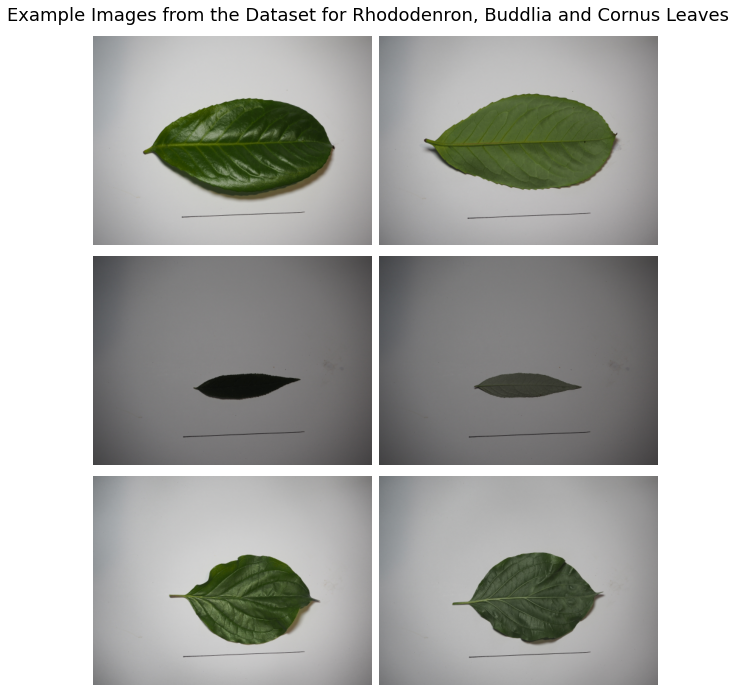

In [2]:
fig, axes = plt.subplots(3, 2, figsize=(10,10))
fig.suptitle(
    'Example Images from the Dataset for Rhododenron, Buddlia and Cornus Leaves',
    fontsize=18
)
fig.tight_layout()

ax = axes[0][0]
ax.imshow(Image.open(f'leaf_dataset/rhododendron/1_f.png'))
ax.axis('off')
ax = axes[0][1]
ax.imshow(Image.open(f'leaf_dataset/rhododendron/1_b.png'))
ax.axis('off')

ax = axes[1][0]
ax.imshow(Image.open(f'leaf_dataset/buddlia/1_f.png'))
ax.axis('off')
ax = axes[1][1]
ax.imshow(Image.open(f'leaf_dataset/buddlia/1_b.png'))
ax.axis('off')

ax = axes[2][0]
ax.imshow(Image.open(f'leaf_dataset/cornus/1_f.png'))
ax.axis('off')
ax = axes[2][1]
ax.imshow(Image.open(f'leaf_dataset/cornus/1_b.png'))
ax.axis('off')

plt.subplots_adjust(wspace=-0.25, hspace=0.05)
plt.show()

## Color Analysis

### Separating Channels
The first thing we can attempt is to look at one of the images with the individual color channels. This is interesting as it highlights the almost black leaf in both the blue and red channels. This is due to high absorption of blue and red light by chlorophyll and thus we observe leaves as primarily the remaining green color.

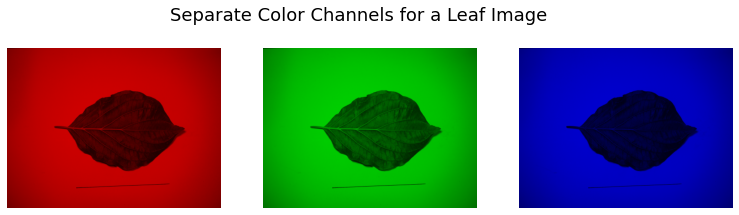

In [3]:
# Separate channels in three different arrays.
img = Image.open(f'leaf_dataset/cornus/4_b.png')
arr_r, arr_g, arr_b = np.asarray(img), np.asarray(img), np.asarray(img)
arr_r[:,:,1:] = 0
arr_g[:,:,0] = 0
arr_g[:,:,2] = 0
arr_b[:,:,0:2] = 0
# Create separated channel images.
img_r = Image.fromarray(arr_r, 'RGB')
img_g = Image.fromarray(arr_g, 'RGB')
img_b = Image.fromarray(arr_b, 'RGB')

# Matplotlib to visualise the separated channel images.
fig, axes = plt.subplots(1, 3, figsize=(13,10))
fig.suptitle(
    'Separate Color Channels for a Leaf Image',
    fontsize=18
)
ax = axes[0]
ax.imshow(img_r)
ax.axis('off')
ax = axes[1]
ax.imshow(img_g)
ax.axis('off')
ax = axes[2]
ax.imshow(img_b)
ax.axis('off')
plt.subplots_adjust(top=1.50)
plt.show()

However, this doesn't help to quantify the color of the leaf, to explore that we will take averages of the channels for each leaf.

### Average Color Analysis
To see if we can identify the leaf type by using color we will take a control sample (red bounding box) and measure the average r, g, and b values for that area. Then iterating over the image, the pixels that are significantly below the control rgb values (shown by the mask below) will have an average taken for their rgb values to give an overall average rgb for the leaf.  
*Note: The 10 cm line is not included when averaging the pixels as the lower section of the image is ignored using boundaries.*

In [4]:
def find_avg_rgb(image, bounds):
    """
        Simple function to return an array for the average of the
        r, g, and b values for every pixel within the boundary of
        a given image. The boundary should be passed as a list of
        bounds [y_min, y_max, x_min, x_max].
    """
    bound_img = image[bounds[0]:bounds[1], bounds[2]:bounds[3]]
    return np.mean(bound_img, axis=(0,1))

def find_avg_rgb_with_filter(image, bounds, filt):
    """
        Simple function to return an array for the average of the
        r, g, and b values for every pixel within the boundary of
        a given image where the points have a rgb value less than
        a provided filter. The boundary should be passed as a list
        of bounds [y_min, y_max, x_min, x_max] and the filter will
        be a list or tuple of three rgb values.
    """
    bound_img = image[bounds[0]:bounds[1], bounds[2]:bounds[3]]
    arr_mask = (bound_img[:,:,0] < filt[0]) | (bound_img[:,:,1] < filt[1]) | (bound_img[:,:,2] < filt[2])
    return np.mean(bound_img[arr_mask], axis=(0))

def get_leaf_avg_rgb(filepath):
    """
        Consolidated function that takes a filepath to a leaf image
        as an argument and returns the average rgb values for the
        leaf.
    """
    img = Image.open(filepath)
    arr = np.asarray(img)
    control_rgb = find_avg_rgb(arr, [0, 30, 0, 40]) * 0.8
    avg_rgb = find_avg_rgb_with_filter(arr, [50, 270, 10, 450], control_rgb)
    return avg_rgb

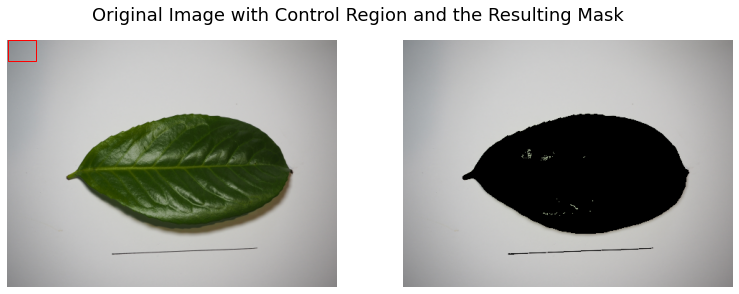

In [5]:
img = Image.open(f'leaf_dataset/rhododendron/1_f.png')
arr = np.asarray(img)
control = find_avg_rgb(arr, [0, 30, 0, 40]) * 0.8
arr[(arr[:,:,0] < control[0]) | (arr[:,:,1] < control[1]) | (arr[:,:,2] < control[2])] = 0
mask = Image.fromarray(arr.astype('uint8'), 'RGB')


fig, axes = plt.subplots(1, 2, figsize=(13,10))
fig.suptitle(
    'Original Image with Control Region and the Resulting Mask',
    fontsize=18
)
ax = axes[0]
ax.imshow(img)
rect = patches.Rectangle((0, 0), 40, 30, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
ax.axis('off')
ax = axes[1]
ax.imshow(mask)
ax.axis('off')
plt.subplots_adjust(top=1.40)
plt.show()

In [6]:
# Rhododendron Data
rhod_f = [get_leaf_avg_rgb(f'leaf_dataset/rhododendron/{i}_f.png') for i in range(0, 15)]
rhod_f = np.array(rhod_f).T
rhod_b = [get_leaf_avg_rgb(f'leaf_dataset/rhododendron/{i}_b.png') for i in range(0, 15)]
rhod_b = np.array(rhod_b).T

# Buddlia Data
budd_f = [get_leaf_avg_rgb(f'leaf_dataset/buddlia/{i}_f.png') for i in range(0, 13)]
budd_f = np.array(budd_f).T
budd_b = [get_leaf_avg_rgb(f'leaf_dataset/buddlia/{i}_b.png') for i in range(0, 13)]
budd_b = np.array(budd_b).T

# Cornus Data
corn_f = [get_leaf_avg_rgb(f'leaf_dataset/cornus/{i}_f.png') for i in range(0, 15)]
corn_f = np.array(corn_f).T
corn_b = [get_leaf_avg_rgb(f'leaf_dataset/cornus/{i}_b.png') for i in range(0, 15)]
corn_b = np.array(corn_b).T

After collecting all the average rgb values for each image we can plot a 3D scatter plot to show the color occupied by different leaf types. We can also examine the histograms for each channel red, green and blue for the distributions of each color for each leaf type.

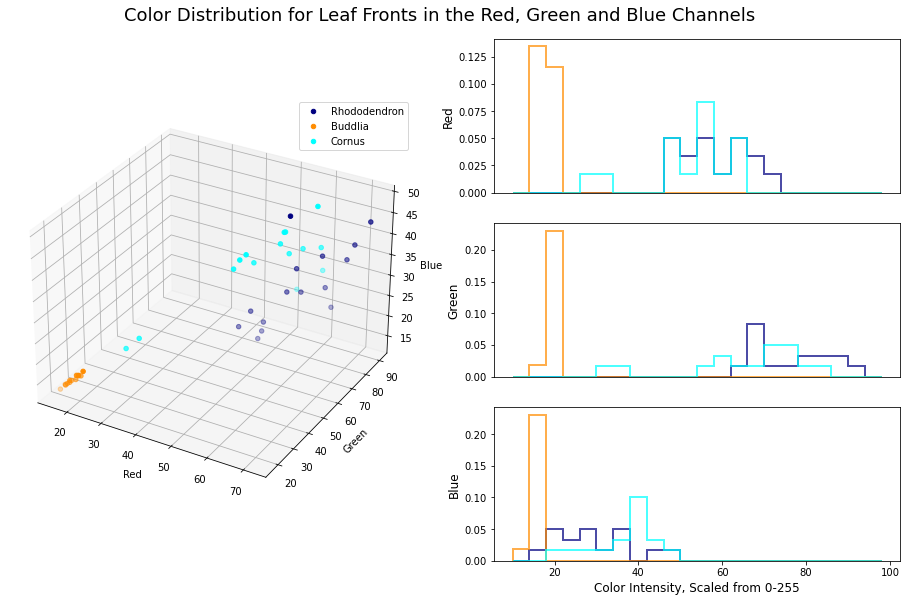

In [7]:
fig = plt.figure(figsize=(16, 9))
fig.tight_layout()
fig.suptitle(
    'Color Distribution for Leaf Fronts in the Red, Green and Blue Channels',
    fontsize=18
)
ax = [None for _ in range(4)]

ax[0] = plt.subplot2grid((3,2), (0,0), colspan=1,rowspan=3, projection='3d')
ax[0].scatter(rhod_f[0], rhod_f[1], rhod_f[2], color='navy', label='Rhododendron')
ax[0].scatter(budd_f[0], budd_f[1], budd_f[2], color='darkorange', label='Buddlia')
ax[0].scatter(corn_f[0], corn_f[1], corn_f[2], color='cyan', label='Cornus')
ax[0].set_xlabel('Red')
ax[0].set_ylabel('Green')
ax[0].set_zlabel('Blue')
ax[0].legend()

ax[1] = plt.subplot2grid((3,2), (0,1), colspan=1)
bin_set = [i for i in range(10, 100, 4)]
ax[1].set_ylabel('Red', fontsize=12)
ax[1].set_xticks([])
ax[1].hist(rhod_f[0], bins=bin_set, density=True, color='navy', histtype='step', lw=2, alpha=0.7)
ax[1].hist(budd_f[0], bins=bin_set, density=True, color='darkorange', histtype='step', lw=2, alpha=0.7)
ax[1].hist(corn_f[0], bins=bin_set, density=True, color='cyan', histtype='step', lw=2, alpha=0.7)

ax[2] = plt.subplot2grid((3,2), (1,1), colspan=1)
ax[2].set_ylabel('Green', fontsize=12)
ax[2].set_xticks([])
ax[2].hist(rhod_f[1], bins=bin_set, density=True, color='navy', histtype='step', lw=2, alpha=0.7)
ax[2].hist(budd_f[1], bins=bin_set, density=True, color='darkorange', histtype='step', lw=2, alpha=0.7)
ax[2].hist(corn_f[1], bins=bin_set, density=True, color='cyan', histtype='step', lw=2, alpha=0.7)

ax[3] = plt.subplot2grid((3,2), (2,1), colspan=1)
ax[3].set_ylabel('Blue', fontsize=12)
ax[3].set_xlabel('Color Intensity, Scaled from 0-255', fontsize=12)
ax[3].hist(rhod_f[2], bins=bin_set, density=True, color='navy', histtype='step', lw=2, alpha=0.7)
ax[3].hist(budd_f[2], bins=bin_set, density=True, color='darkorange', histtype='step', lw=2, alpha=0.7)
ax[3].hist(corn_f[2], bins=bin_set, density=True, color='cyan', histtype='step', lw=2, alpha=0.7)
plt.subplots_adjust(top=0.93)
plt.show()

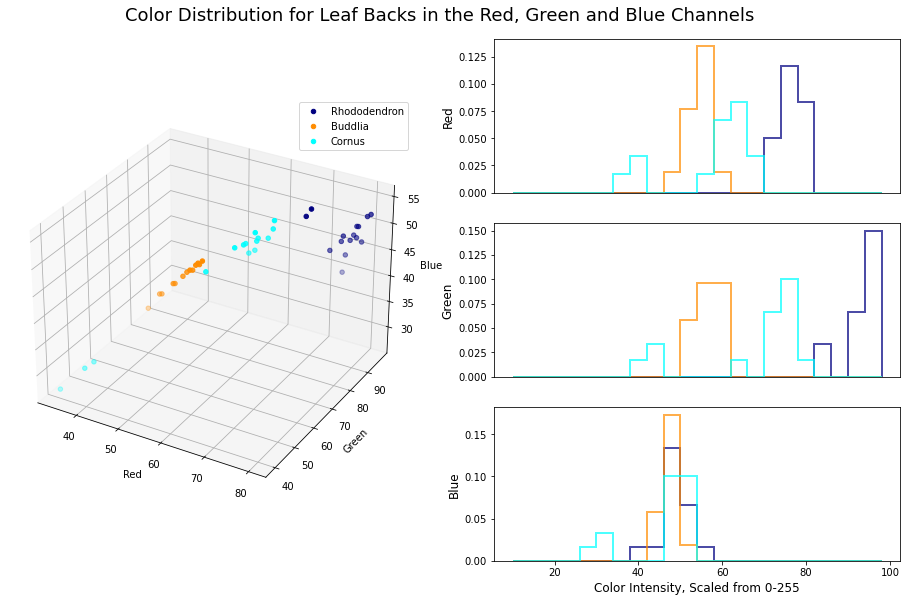

In [8]:
fig = plt.figure(figsize=(16, 9))
fig.tight_layout()
fig.suptitle(
    'Color Distribution for Leaf Backs in the Red, Green and Blue Channels',
    fontsize=18
)
ax = [None for _ in range(4)]

ax[0] = plt.subplot2grid((3,2), (0,0), colspan=1,rowspan=3, projection='3d')
ax[0].scatter(rhod_b[0], rhod_b[1], rhod_b[2], color='navy', label='Rhododendron')
ax[0].scatter(budd_b[0], budd_b[1], budd_b[2], color='darkorange', label='Buddlia')
ax[0].scatter(corn_b[0], corn_b[1], corn_b[2], color='cyan', label='Cornus')
ax[0].set_xlabel('Red')
ax[0].set_ylabel('Green')
ax[0].set_zlabel('Blue')
ax[0].legend()

ax[1] = plt.subplot2grid((3,2), (0,1), colspan=1)
bin_set = [i for i in range(10, 100, 4)]
ax[1].set_ylabel('Red', fontsize=12)
ax[1].set_xticks([])
ax[1].hist(rhod_b[0], bins=bin_set, density=True, color='navy', histtype='step', lw=2, alpha=0.7)
ax[1].hist(budd_b[0], bins=bin_set, density=True, color='darkorange', histtype='step', lw=2, alpha=0.7)
ax[1].hist(corn_b[0], bins=bin_set, density=True, color='cyan', histtype='step', lw=2, alpha=0.7)

ax[2] = plt.subplot2grid((3,2), (1,1), colspan=1)
ax[2].set_ylabel('Green', fontsize=12)
ax[2].set_xticks([])
ax[2].hist(rhod_b[1], bins=bin_set, density=True, color='navy', histtype='step', lw=2, alpha=0.7)
ax[2].hist(budd_b[1], bins=bin_set, density=True, color='darkorange', histtype='step', lw=2, alpha=0.7)
ax[2].hist(corn_b[1], bins=bin_set, density=True, color='cyan', histtype='step', lw=2, alpha=0.7)

ax[3] = plt.subplot2grid((3,2), (2,1), colspan=1)
ax[3].set_ylabel('Blue', fontsize=12)
ax[3].set_xlabel('Color Intensity, Scaled from 0-255', fontsize=12)
ax[3].hist(rhod_b[2], bins=bin_set, density=True, color='navy', histtype='step', lw=2, alpha=0.7)
ax[3].hist(budd_b[2], bins=bin_set, density=True, color='darkorange', histtype='step', lw=2, alpha=0.7)
ax[3].hist(corn_b[2], bins=bin_set, density=True, color='cyan', histtype='step', lw=2, alpha=0.7)
plt.subplots_adjust(top=0.93)
plt.show()

It is clear to see in the 3D scatter plot that typically the Buddlia leaves occupy a color domain that is removed from both the Rhododendron and Cornus Leaves. However, this may be an artefact of the camera altering exposure for these darker leaves. Nonetheless, it appears that the rgb profile of the leaves could be used to identify the leaves, especially in the red and green channels. We can construct a palette for these leaves using the average color of the front and back of each leaf species.

### Color Palette

In [9]:
# Create array with the two colors for each one and then use img matplotlib to show with y-axis labelled...
rhod_f_rgb = np.mean(rhod_f, axis=1)
rhod_b_rgb = np.mean(rhod_b, axis=1)
budd_f_rgb = np.mean(budd_f, axis=1)
budd_b_rgb = np.mean(budd_b, axis=1)
corn_f_rgb = np.mean(corn_f, axis=1)
corn_b_rgb = np.mean(corn_b, axis=1)

color_palette = np.zeros((6000, 10000, 3))
color_palette[0:2000, 0:5000] = np.mean(rhod_f, axis=1)
color_palette[0:2000, 5000:10000] = np.mean(rhod_b, axis=1)
color_palette[2000:4000, 0:5000] = np.mean(budd_f, axis=1)
color_palette[2000:4000, 5000:10000] = np.mean(budd_b, axis=1)
color_palette[4000:6000, 0:5000] = np.mean(corn_f, axis=1)
color_palette[4000:6000, 5000:10000] = np.mean(corn_b, axis=1)

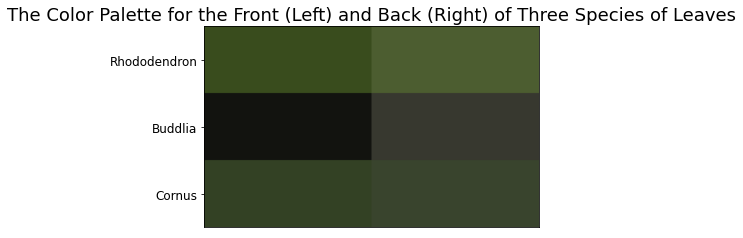

In [10]:
palette = Image.fromarray(color_palette.astype('uint8'), 'RGB')
plt.imshow(palette)
plt.title('The Color Palette for the Front (Left) and Back (Right) of Three Species of Leaves', fontsize=18)
y_label_list = ['Rhododendron', 'Buddlia', 'Cornus']
plt.yticks([1000,3000,5000], y_label_list, fontsize=12)
plt.xticks([])
plt.show()

Overall, the color analysis suggests that there is potential for the color profile of the leaf to be used to classify them. Though it would be valuable to create a new dataset of leaf images with a set aperture on the camera for normalised exposure. It would be interesting to see if this color analysis also applied to a canopy for identifying tree species.

## Shape Analysis

### Image Processing
In order to measure objects in the images we must first prepare them for analysis by highlighting key features. This involves converting them to greyscale, enhancing the image by sharpening and increasing contrast, then performing edge detection with a 'Sobel' kernel.

In [11]:
def image_processing(image):
    """
        Function to perform basic image processing.
        This takes a loaded image as an argument
        and returns the highlighted edges of the 
        image.
    """
    img_greyscale = image.convert('L')
    enhancer = ImageEnhance.Sharpness(img_greyscale)
    img_enhanced = enhancer.enhance(1.1) 
    enhancer = ImageEnhance.Contrast(img_enhanced)
    img_enhanced = enhancer.enhance(1.1)
    img_edges = img_enhanced.filter(ImageFilter.FIND_EDGES)
    return img_edges

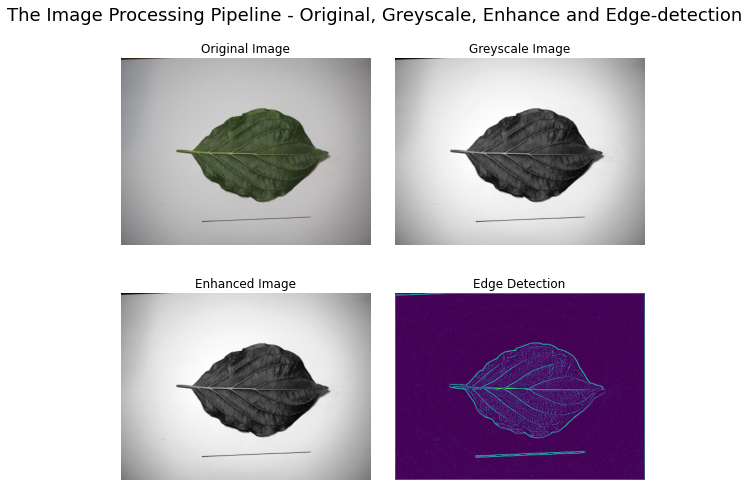

In [12]:
img_original = Image.open(f'leaf_dataset/cornus/4_b.png')
img_greyscale = img_original.convert('L')
enhancer = ImageEnhance.Sharpness(img_greyscale)
img_enhanced = enhancer.enhance(1.1) 
enhancer = ImageEnhance.Contrast(img_enhanced)
img_enhanced = enhancer.enhance(1.1)
img_edges = img_enhanced.filter(ImageFilter.FIND_EDGES)

fig, axes = plt.subplots(2, 2, figsize=(8,8))
fig.suptitle(
    'The Image Processing Pipeline - Original, Greyscale, Enhance and Edge-detection',
    fontsize=18
)
fig.tight_layout()

ax = axes[0][0]
ax.imshow(img_original)
ax.axis('off')
ax.set_title('Original Image')

ax = axes[0][1]
ax.imshow(img_greyscale, cmap='gray')
ax.axis('off')
ax.set_title('Greyscale Image')

ax = axes[1][0]
ax.imshow(img_enhanced, cmap='gray')
ax.axis('off')
ax.set_title('Enhanced Image')

ax = axes[1][1]
ax.imshow(img_edges)
ax.axis('off')
ax.set_title('Edge Detection')

plt.subplots_adjust(wspace=0.1, hspace=-0.25, top=1)
plt.show()

Some images also require brightening after edge detection, particularly the more underexposed buddlia images.

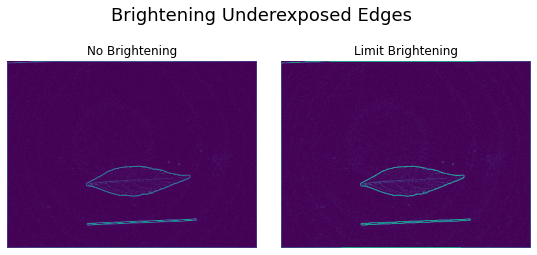

In [13]:
bud_img = image_processing(Image.open(f'leaf_dataset/buddlia/7_b.png'))
bud_arr = np.asarray(bud_img)
bud_arr[bud_arr > 100] = 200
bud_img_b = Image.fromarray(bud_arr, 'L')

fig, axes = plt.subplots(1, 2, figsize=(8,8))
fig.suptitle(
    'Brightening Underexposed Edges',
    fontsize=18
)
fig.tight_layout()

ax = axes[0]
ax.imshow(bud_img)
ax.axis('off')
ax.set_title('No Brightening')

ax = axes[1]
ax.imshow(bud_img_b)
ax.axis('off')
ax.set_title('Limit Brightening')

plt.subplots_adjust(wspace=0.1, top=1.4)
plt.show()

### Distance Measurements
The processed images can then be used to measure the size of a pixel using the known 100 mm long line (red bounding box). This can be used to measure the length and width of the leaf (yellow bounding box).

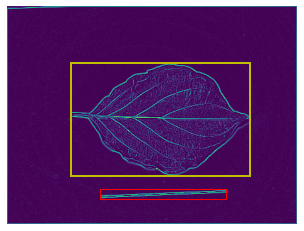

In [14]:
img_cor = image_processing(Image.open(f'leaf_dataset/cornus/4_b.png'))
fig, ax = plt.subplots()
ax.imshow(img_cor)
rect_1 = patches.Rectangle((146, 290), 201, 15, linewidth=1, edgecolor='r', facecolor='none')
rect_2 = patches.Rectangle((100, 90), 284, 178, linewidth=2, edgecolor='y', facecolor='none')
ax.add_patch(rect_1)
ax.add_patch(rect_2)
ax.axis('off')
plt.show()

In [15]:
def get_leaf_length_and_width(filepath, bounds, limit=None):
    """
        A consolidating functions which takes in the filepath
        to an image, the boundary requirements for the leaf
        measurement (organised as [y_min, y_max, x_min, x_max])
        and whether a limit should be applied for underexposed
        images. This returns two floats for the leaf length and
        leaf width.
    """
    img = image_processing(Image.open(filepath))
    arr = np.asarray(img)
    if limit:
        arr[arr>limit] = 255
    
    line_left = get_contrast_point(arr, [276, 340, 120, 360], 100, axis=1, reverse=False)
    line_right = get_contrast_point(arr, [276, 340, 120, 360], 100, axis=1, reverse=True)
    line_length = math.dist(line_left, line_right)
    # This gives pixel size in millimeters.
    pixel_size = 100 / line_length
    
    # Length of the leaf
    leaf_left = get_contrast_point(arr, bounds, 200, axis=1, reverse=False)
    leaf_right = get_contrast_point(arr, bounds, 200, axis=1, reverse=True)
    leaf_length = math.dist(leaf_left, leaf_right) * pixel_size
    
    # Width of the leaf
    leaf_top = get_contrast_point(arr, bounds, 200, axis=0, reverse=False)
    leaf_bottom = get_contrast_point(arr, bounds, 200, axis=0, reverse=True)
    leaf_width = math.dist(leaf_top, leaf_bottom) * pixel_size
    
    return leaf_length, leaf_width


def get_contrast_point(image, bounds, control, axis=0, reverse=False):
    """
        A function that returns the first point it encounters
        above a control value with the bounds of a given image.
        This can iterate either the y or x axes (indicated by
        0 or 1 respectively) and from top to bottom/left to 
        right or bottom to top/right to left using the reverse
        boolean. This function returns the first point found.
    """
    if axis == 0 and not reverse:
        for i in range(bounds[0], bounds[1]):
            for j in range(bounds[2], bounds[3]):
                if image[i,j] > control:
                    return (i, j)
    elif axis == 0 and reverse:
        for i in range(bounds[1]-1, bounds[0], -1):
            for j in range(bounds[2], bounds[3]):
                if image[i,j] > control:
                    return (i, j)
    elif axis == 1 and not reverse:
        for j in range(bounds[2], bounds[3]):
            for i in range(bounds[0], bounds[1]):
                if image[i,j] > control:
                    return (i, j)
    elif axis == 1 and reverse:
        for j in range(bounds[3]-1, bounds[2], -1):
            for i in range(bounds[0], bounds[1]):
                if image[i,j] > control:
                    return (i, j)

In [16]:
length, width = get_leaf_length_and_width(f'leaf_dataset/cornus/4_b.png', [50, 276, 0, 460])
print(f'Leaf Length: {length:.2f} mm')
print(f'Leaf Width: {width:.2f} mm')  

Leaf Length: 139.25 mm
Leaf Width: 86.58 mm


This function can be used to perform processing for all the images and store the results in a dataframe for analysis and visualisation.

In [17]:
data = []
columns = ['Type', 'Front_Length_mm', 'Front_Width_mm', 'Front_Ratio', 'Back_Length_mm', 'Back_Width_mm', 'Back_Ratio']

# Rhododendron Data
for i in range(0, 15):
    f_length, f_width = get_leaf_length_and_width(f'leaf_dataset/rhododendron/{i}_f.png', [50, 276, 0, 460])
    f_ratio = f_length/f_width
    b_length, b_width = get_leaf_length_and_width(f'leaf_dataset/rhododendron/{i}_b.png', [50, 276, 0, 460])
    b_ratio = b_length/b_width
    data.append(['Rhododendron', f_length, f_width, f_ratio, b_length, b_width, b_ratio])
    
# Buddlia Data
for i in range(0, 13):
    f_length, f_width = get_leaf_length_and_width(f'leaf_dataset/buddlia/{i}_f.png', [50, 276, 0, 460], 110)
    f_ratio = f_length/f_width
    b_length, b_width = get_leaf_length_and_width(f'leaf_dataset/buddlia/{i}_b.png', [50, 276, 0, 460], 110)
    b_ratio = b_length/b_width
    data.append(['Buddlia', f_length, f_width, f_ratio, b_length, b_width, b_ratio])

# Cornus Data
for i in range(0, 15):
    f_length, f_width = get_leaf_length_and_width(f'leaf_dataset/cornus/{i}_f.png', [50, 276, 0, 460])
    f_ratio = f_length/f_width
    b_length, b_width = get_leaf_length_and_width(f'leaf_dataset/cornus/{i}_b.png', [50, 276, 0, 460])
    b_ratio = b_length/b_width
    data.append(['Cornus', f_length, f_width, f_ratio, b_length, b_width, b_ratio])

leaf_shape_df = pd.DataFrame(data, columns=columns)

In [18]:
leaf_shape_df.head()

,Type,Front_Length_mm,Front_Width_mm,Front_Ratio,Back_Length_mm,Back_Width_mm,Back_Ratio
0,Rhododendron,187.666505,68.641522,2.734009,189.474807,82.407467,2.299243
1,Rhododendron,154.860451,71.581876,2.163403,157.606236,78.451443,2.008965
2,Rhododendron,159.066066,76.793996,2.071335,162.975298,76.651887,2.126175
3,Rhododendron,139.314656,65.961598,2.112057,140.135026,63.958765,2.191021
4,Rhododendron,148.836335,64.923835,2.292476,150.943375,60.626120,2.489742


In [19]:
leaf_shape_df.describe()

,Front_Length_mm,Front_Width_mm,Front_Ratio,Back_Length_mm,Back_Width_mm,Back_Ratio
count,43.000000,43.000000,43.000000,43.000000,43.000000,43.000000
mean,126.658638,57.475333,2.424929,126.816067,57.635334,2.463830
std,34.472997,22.168711,0.699512,34.751110,23.430948,0.764971
min,76.425897,19.530607,1.628172,74.992923,20.035895,1.575973
25%,95.477717,31.369745,1.957757,94.584911,29.074351,1.935239
50%,122.970080,64.923835,2.112057,124.226842,63.958765,2.109288
75%,153.018147,76.036953,2.853926,156.059673,76.732171,3.173688
max,211.005441,85.518417,4.206966,199.444993,88.912003,4.038657


### Visualising Distance Data
A simple visualisation of the length and width data can be created using a scatter plot for both the front and back of the leaves. Both plots should be roughly similar, however, the back of the leaves had less obvious artefacts due to curves in some of the leaves midribs. 

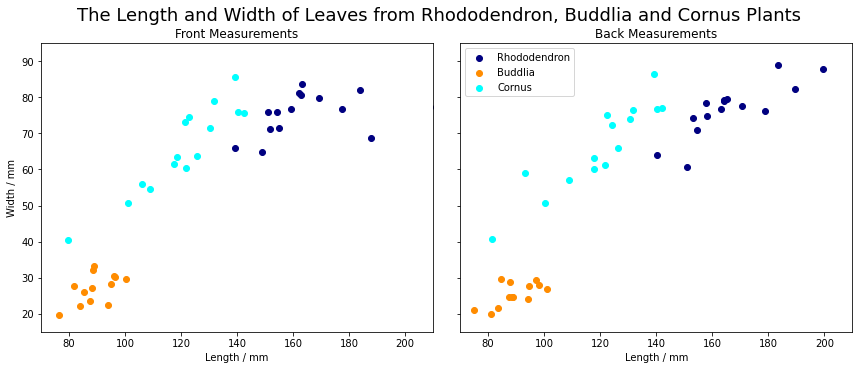

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(12,5), sharey=True)
fig.suptitle(
    'The Length and Width of Leaves from Rhododendron, Buddlia and Cornus Plants',
    fontsize=18
)
fig.tight_layout()

ax = axes[0]
ax.scatter(data=leaf_shape_df[leaf_shape_df['Type'] == 'Rhododendron'], x='Front_Length_mm', y='Front_Width_mm', c='navy', label='Rhododendron')
ax.scatter(data=leaf_shape_df[leaf_shape_df['Type'] == 'Buddlia'], x='Front_Length_mm', y='Front_Width_mm', c='darkorange', label='Buddlia')
ax.scatter(data=leaf_shape_df[leaf_shape_df['Type'] == 'Cornus'], x='Front_Length_mm', y='Front_Width_mm', c='cyan', label='Cornus')
ax.set_title('Front Measurements')
ax.set_ylim(15, 95)
ax.set_xlim(70, 210)
ax.set_xlabel('Length / mm')
ax.set_ylabel('Width / mm')

ax = axes[1]
ax.scatter(data=leaf_shape_df[leaf_shape_df['Type'] == 'Rhododendron'], x='Back_Length_mm', y='Back_Width_mm', c='navy', label='Rhododendron')
ax.scatter(data=leaf_shape_df[leaf_shape_df['Type'] == 'Buddlia'], x='Back_Length_mm', y='Back_Width_mm', c='darkorange', label='Buddlia')
ax.scatter(data=leaf_shape_df[leaf_shape_df['Type'] == 'Cornus'], x='Back_Length_mm', y='Back_Width_mm', c='cyan', label='Cornus')
ax.set_title('Back Measurements')
ax.set_ylim(15, 95)
ax.set_xlim(70, 210)
ax.set_xlabel('Length / mm')
ax.legend()

plt.show()

We can also plot histograms of the ratios of length to width for each leaf. This helps to identify leaves that may be long and thin or short and wide. It is another numerical identifier that can provide information about the overall shape of the leaf.

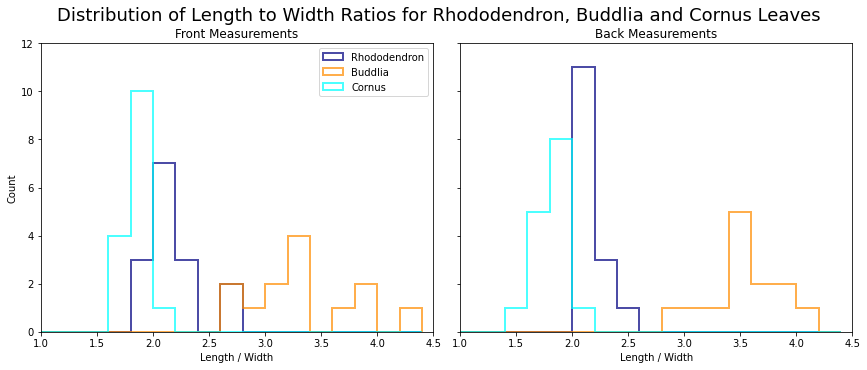

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(12,5), sharey=True)
fig.suptitle(
    'Distribution of Length to Width Ratios for Rhododendron, Buddlia and Cornus Leaves',
    fontsize=18
)
fig.tight_layout()
bin_set = [i/10 for i in range(10, 45, 2)]

ax = axes[0]
ax.hist(data=leaf_shape_df[leaf_shape_df['Type'] == 'Rhododendron'],
         x='Front_Ratio', bins=bin_set, color='navy', histtype='step', label='Rhododendron', alpha=0.7, lw=2)
ax.hist(data=leaf_shape_df[leaf_shape_df['Type'] == 'Buddlia'],
         x='Front_Ratio', bins=bin_set, color='darkorange', histtype='step', label='Buddlia', alpha=0.7, lw=2)
ax.hist(data=leaf_shape_df[leaf_shape_df['Type'] == 'Cornus'],
         x='Front_Ratio', bins=bin_set, color='cyan', histtype='step', label='Cornus', alpha=0.7, lw=2)
ax.set_title('Front Measurements')
ax.set_ylim(0, 12)
ax.set_xlim(1.0, 4.5)
ax.set_xlabel('Length / Width')
ax.set_ylabel('Count')
ax.legend()

ax = axes[1]
ax.hist(data=leaf_shape_df[leaf_shape_df['Type'] == 'Rhododendron'],
         x='Back_Ratio', bins=bin_set, color='navy', histtype='step', label='Rhododendron', alpha=0.7, lw=2)
ax.hist(data=leaf_shape_df[leaf_shape_df['Type'] == 'Buddlia'],
         x='Back_Ratio', bins=bin_set, color='darkorange', histtype='step', label='Buddlia', alpha=0.7, lw=2)
ax.hist(data=leaf_shape_df[leaf_shape_df['Type'] == 'Cornus'],
         x='Back_Ratio', bins=bin_set, color='cyan', histtype='step', label='Cornus', alpha=0.7, lw=2)
ax.set_title('Back Measurements')
ax.set_ylim(0, 12)
ax.set_xlim(1.0, 4.5)
ax.set_xlabel('Length / Width')

plt.show()

## Summary

We've explored how to process images in methods that can be easily incorporated into a pipeline and to extract meaningful data for properties such as color and shape. This data can be used for further analysis and to inform future data collection.  

This EDA has found that the images can be processed to extract color and shape information. 
1. The **color analysis** has provided a potential palette that can be used to classify new leaf images. However, the color contrast is not uniform across the images and it could be useful to explore normalising the color range to a given background value. 
2. The **shape analysis** has enabled measurement of the length and width of the different leaves which can also potentially be used to classify new leaf images. The ratio of length to width also provide a useful value to describe the overall shape of the leaf.  

This initial exploration has focused primarily on image processing to transform unstructured data into structured data. However, there are others areas that could be explored further including:
1. Measuring the area of the leaves by pixel counting.
2. Analysing the matt or glossy surfaces by measuring pixels in the leaf boundary over a certain threshold.
3. Detail analysis such as recognition of structural components like veins and the different color profile between the components.